In [1]:
from IPython.display import display, Math, Latex

$$\Huge{Κώδικας\ και\ Ανάλυση\ Μεθόδων}\\ Aρχικά\ κάνουμε\ εισαγωγή\ των\ βιβλιοθηκών\ που\ θα\ χρησιμοποιήσουμε.$$

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import GaussianNB
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from scipy import stats

$$Στη\ συνέχεια\ εισάγουμε\ το\ dataset\ που\ θα\ χρησιμοποιήσουμε\ ως\ ένα\ Pandas\ DataFrame\ και\ το\ ελέγχουμε\ συνοπτικά.$$

In [54]:
data = pd.read_csv(r'C:\Users\user\Desktop\datasets\dokimastika\data.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


$$Θα\ κρατήσουμε\ ως\ labels\ των\ κατηγοριών\ μας\ το\ χαρακτηριστικό\ 'diagnosis'\ και\ τα\ features\ 2-31\ θα\ χρησιμοποιηθούν\\ ως\ δεδομένα\ ανάλυσης.\\ Αρχικά\ για\ να\ έχουμε\ μια\ πρώτη\ εικόνα\ του\ δείγματός\ μας,\ θα\ φτιάξουμε\ ένα\ pie\ chart\ που\ θα\ μας\ δείχνει\ την\ κατανομή\ των\ κατηγοριών.$$

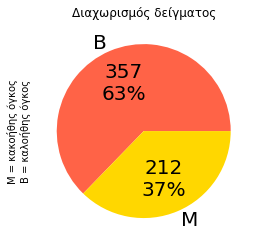

In [55]:
def label_function(val):
    return f'{val / 100 * len(data):.0f}\n{val:.0f}%'

data.groupby('diagnosis').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 20},
                                  colors=['tomato', 'gold', 'skyblue'])
plt.title('Διαχωρισμός δείγματος')
plt.ylabel('Μ = κακοήθης όγκος\nΒ = καλοήθης όγκος')
plt.show()

$$Παρατηρούμε\ λοιπόν\ ότι\ στο\ δείγμα\ μας\ έχουμε\ 37\% \ κακοήθεις\ όγκους\ (M\ =\ Maligant)\ και\ 63\%\ καλοήθεις\ (B\ =\ Benign).\\ Έπειτα\ διαχωρίζουμε\ τα\ δεδομένα\ που\ θα\ χρησιμοποιήσουμε\ X\ (τροποποιώντας\ τα\ σε\ numpy\ arrays)\ σε\ σχέση\ με\ τους\ κατηγοριοποιητές\ Y\\ και\ μετασχηματίζουμε\ τα\ labels\ των\ κατηγοριών\ τοποθετώντας\ 1\ στα\ labels\ των\ κακοήθων\ όγκων\ και\ 0\ στα\ labels\ των\ καλοήθων\ όγκων.$$

In [56]:
new_data = data.to_numpy()
X = new_data[:, 3:31]
Y = new_data[:,1]
for i in range(len(Y)):
    if Y[i] == 'M':
        Y[i]=1
    else:
        Y[i] = 0

Y = list(Y)

$$Στη\ μελέτη\ μας\ η\ οποία\ αποσκοπεί\ στη\ σύγκριση\ των\ διαφόρων\ μεθόδων\ εξαγωγής\ χαρακτηριστικών,\ θα\ χρησιμοποιήσουμε\ ως\ classifiers\\ δέντρα\ αποφάσεων\ και\ Naive\ Bayes.\ Όσον\ αφορά\ τα\ δέντρα\ αποφάσεων,\ για\ να\ υπάρχει\ ποικιλία,\ θα\ χρησιμοποιηθεί\ ο\ CART\ αλγόριθμος\\ για\ την\ επαγωγή\ τους,\ ενώ\ ως\ μέτρα\ επιλογής\ χαρακτηριστιών\ θα\ χρησιμοποιήσουμε\ τον\ δείκτη\ Gini\ και\ την\ Εντροπία.\\ Αρχικά\ θα\ χρησιμοποιήσουμε\ PCA\ για\ να\ επιλέξουμε\ μικρότερο\ πλήθος\ χαρακτηριστικών\ και\ για\ κάθε\ διαφορετική\ επιλογή\ πλήθους\ θα\\ εκπαιδεύσουμε\ τα\ μοντέλα\ μας\ και\ θα\ δούμε\ την\ αποτελεσματικότητά\ τους\ όσον\ αφορά\ την\ προβλεπτική\ τους\ ικανότητα\ σε\ κάθε\\ περίπτωση.\ Στη\ συνέχεια\ θα\ κάνουμε\ πάλι\ εξαγωγή\ χαρακτηριστικών\ με\ τη\ βοήθεια\ της\ LDA\ επιλέγοντας\ μόνο\ ένα\ χαρακτηριστικό,\ ενώ\\ τέλος\ θα\ εφαρμόσουμε\ πάλι\ εξαγωγή\ χαρακτηριστικών\ με\ kenrel\ PCA\ για\ διάφορους\ πυρήνες.$$

$$Με\ το\ διαχωρισμό\ του\ δείγματος\ σε\ train/test\ set\ ασχοληθήκαμε\ αρκετά\ στο\ Notebook\ που\ εξετάσαμε\ τις\ μεθόδους\ επιλογής\\ χαρακτηριστικών.\ Εδώ\ θα\ κρατήσουμε\ το\ μοτίβο\ 75/25.$$

$$Τώρα\ θα\ ξεκινήσουμε\ με\ την\ PCA.$$

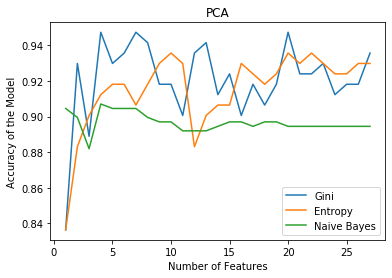

In [57]:
t = [i for i in range(1,28)]
Gini = []
Entropy = []
Naive_Bayes = []



for i in range(1, 28):
    pca = PCA(n_components=i , svd_solver='auto')
    X_new = pca.fit_transform(X, Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=.3, random_state=0)
        
    dtGini = DecisionTreeClassifier(criterion='gini', random_state=0)
    dtEntropy = DecisionTreeClassifier(criterion='entropy', random_state=0)
    NB = GaussianNB()

    dtGini.fit(X_train, Y_train)
    dtEntropy.fit(X_train, Y_train)
    NB.fit(X_train, Y_train)
        
    Gini_score = dtGini.score(X_test, Y_test)
    Entropy_score = dtEntropy.score(X_test, Y_test)
    NB_score = NB.score(X_train, Y_train)
    Gini.append(Gini_score)
    Entropy.append(Entropy_score)
    Naive_Bayes.append(NB_score)


plt.plot(t, Gini)
plt.plot(t, Entropy)
plt.plot(t, Naive_Bayes)

plt.xlabel('Number of Features')
plt.ylabel('Accuracy of the Model')
plt.title('PCA')
plt.legend(['Gini', 'Entropy', 'Naive Bayes'])
plt.show()

$$Παρατηρούμε\ ότι\ σε\ κάθε\ περίπτωση\ επιλογής\ χαρακτηριστικών\ ο\ Naive\ Bayes\ διατηρεί\ σχεδόν\ σταθερή\ την\ επίδοσή\ του.\\ Το\ ίδιο\ φαίνεται\ να\ ισχύει\ για\ τα\ desicion\ trees\ για\ πλήθος\ χαρακτηριστικών\ μεγαλύτερο\ ή\ ίσο\ του\ 5,\ ενώ\ για\ d<5\ παρατηρείται\ μια\ μικρή\\ πτώση\ στην\ απόδοση.\\ Τα\ παραπάνω\ συμπεράσματα\ μπορούν\ να\ γίνουν\ πιο\ εύκολα\ κατανοητά\ φτιάχνοντας\ μια\ συνεχή\ προσέγγιση\ της\ πυκνότητας\ των\ τιμών,\\ όπως\ παρακάτω.$$

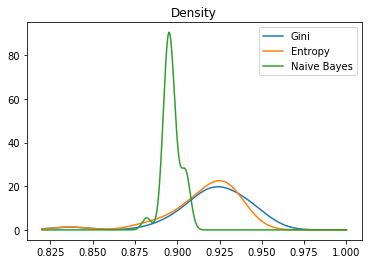

In [58]:
density_gini = stats.kde.gaussian_kde(Gini)
density_entropy = stats.kde.gaussian_kde(Entropy)
density_nb = stats.kde.gaussian_kde(Naive_Bayes)

t = np.linspace(.82, 1, 1000)
plt.plot(t, density_gini(t))
plt.plot(t, density_entropy(t))
plt.plot(t, density_nb(t))

plt.title('Density')
plt.legend(['Gini', 'Entropy', 'Naive Bayes'])
plt.show()

In [59]:
print('Gini Accuracy Variation =', np.var(Gini),
      '\nEntropy Accuracy Variation =', np.var(Entropy), 
      '\nNaive Bayes Accuracy Variation =', np.var(Naive_Bayes))

Gini Accuracy Variation = 0.0004922903364589123 
Entropy Accuracy Variation = 0.0004466922606977093 
Naive Bayes Accuracy Variation = 2.6048586363655176e-05


$$Απ'\ το\ παραπάνω\ διάγραμμα\ επιβεβαιώνεται\ η\ παρατήρηση\ που\ κάναμε\ παραπάνω\ σχετικά\ με\ τη\ διασπορά\ του\ accuracy\ σε\ κάθε\ μοντέλο.$$

In [60]:
print('Gini Mean Accuracy =', np.mean(Gini),
     '\nEntropy Mean Accuracy =', np.mean(Entropy),
     '\nNaive Bayes mean Accuracy =', np.mean(Naive_Bayes))

Gini Mean Accuracy = 0.9207277452891489 
Entropy Mean Accuracy = 0.9155295646523718 
Naive Bayes mean Accuracy = 0.896612693095105


$$Η\ εικόνα\ που\ σχηματίζουμε,\ είναι\ ότι\ η\ PCA\ φαίνεται\ να\ δίνει\ τα\ ίδια\ αποτελέσματα\ και\ στα\ δύο\ decision\ trees\ με\ καλύτερο\ μέσο\ accuracy,\ αλλά\ μείωσή\ του\ από\ κάποια\ critical\ τιμή\ του\ πλήθους\ χαρακτηριστικών\ (εδώ\ αυτή\ φαίνεται\ να\ είναι\ το\ 5).\ Από\ την\ άλλη,\ η\ Naive\ Bayes\\ φαίνεται\ να\ έχει\ πιο\ σταθερή\ (αν\ και\ χαμηλότερη)\ απόδοση\ ανεξαρτήτου\ πλήθους\ εξαγωμένων\ χαρακτηριστικών\ απ'\ την\ PCA$$

$$Τώρα\ θα\ τρέξουμε\ την\ LDA.$$

Original Number of Features: 28
Reduced Number of Features: 1

 +--------------------+-----------+-------------+
| Accuracy per Model | 1 Feature | 28 Features |
+--------------------+-----------+-------------+
| Gini               | 0.953     | 0.918       |
+--------------------+-----------+-------------+
| Entropy            | 0.953     | 0.971       |
+--------------------+-----------+-------------+
| Naive Bayes        | 0.982     | 0.912       |
+--------------------+-----------+-------------+


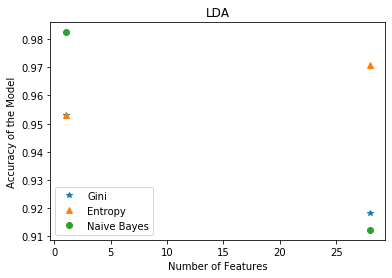

In [61]:
from tabulate import tabulate

t_lda = [1, 28]
Gini_lda = [0, 0]
Entropy_lda=[0, 0]
Naive_Bayes_lda = [0,0]

lda = LinearDiscriminantAnalysis(solver='eigen')
X_new = lda.fit_transform(X, Y)

print('Original Number of Features:', X.shape[1])
print('Reduced Number of Features:', X_new.shape[1])

X_train_original, X_test_original, Y_train_original, Y_test_original = train_test_split(X, Y, test_size=.3, random_state=0)

dtGini = DecisionTreeClassifier(criterion='gini', random_state=0)
dtEntropy = DecisionTreeClassifier(criterion='entropy', random_state=0)
NB = GaussianNB()

dtGini.fit(X_train_original, Y_train_original)
dtEntropy.fit(X_train_original, Y_train_original)
NB.fit(X_train_original, Y_train_original)
        
Gini_lda[1]= dtGini.score(X_test_original, Y_test_original)
Entropy_lda[1] = dtEntropy.score(X_test_original, Y_test_original)
Naive_Bayes_lda[1] = NB.score(X_test_original, Y_test_original)

X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=.3, random_state=0)

dtGini.fit(X_train, Y_train)
dtEntropy.fit(X_train, Y_train)
NB.fit(X_train, Y_train)

Gini_lda[0]= dtGini.score(X_test, Y_test)
Entropy_lda[0] = dtEntropy.score(X_test, Y_test)
Naive_Bayes_lda[0] = NB.score(X_test, Y_test)

table = [['Accuracy per Model', '1 Feature', '28 Features'], ['Gini', Gini_lda[0].round(3), Gini_lda[1].round(3)], ['Entropy', Entropy_lda[0].round(3), Entropy_lda[1].round(3)], ['Naive Bayes', Naive_Bayes_lda[0].round(3), Naive_Bayes_lda[1].round(3)]]

print('\n', tabulate(table, tablefmt='grid'))

plt.plot(t_lda, Gini_lda, '*')
plt.plot(t_lda, Entropy_lda, '^')
plt.plot(t_lda, Naive_Bayes_lda, 'o')

plt.title('LDA')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy of the Model')
plt.legend(['Gini', 'Entropy', 'Naive Bayes'])
plt.show()

$$Παρατηρούμε\ ότ\ το\ accuracy\ του\ Gini\ και\ του\ Entropy\ για\ 1\ χαρακτηριστικό\ ταυτίζονται\ με\ του\ Gini\ να\ πέφτει,\ ενώ\ του\ Entropy\ να\\ αυξάνεται.\ Από\ την\ άλλη,\ βλέπουμε\ ότι\ ο\ Naive\ Bayes\ αύξησε\ το\ Accuracy\ του.\ Εδώ\ παρατηρούμε\ μια\ αντίθεση\ σε\ σχέση\ με\ την\ PCA\\ όπου\ τα\ desicion\ trees\ φάνηκαν\ να\ συμπεριφέρονται\ παρόμοια\ όταν\ οι\ διαστάσεις\ του\ χώρο\ χαρακτηριστικών\ έπεσαν.$$

$$Κλείνουμε\ την\ αναφορά\ μας\ στις\ μεθόδους\ εξαγωγής\ χαρακτηριστικών\ με\ εφαρμογή\ της\ Kernel\ PCA\ για\ διάφορους\\ πυρήνες.\ Πιο\ συγκεκριμένα\ θα\ δούμε\ πως\ συμπεριφέρονται\ οι\ προβλέψεις\ των\ μοντέλων\ μας\ επιλέγοντας\ ως\ πυρήνες\\ 1) Τον\ γραμμικό\ πυρήνα\ που\ ορίζεται\ ως\ k(x,y) = x^t y\\ 2)Τον\ πολυωνυμικό\ πυρήνα\ που\ ορίζεται\ ως\ k(x,y)=(\gamma x^t y+\beta )^d , για\ τις\ διάφορες\ τιμές\ των\ \gamma ,\beta \ και\ d\\ 3) Τον\ Gaussian\ ή\ RBF\ (Radial\ basis\ function)\ πυρήνα\ που\ ορίζεται\ ως\ k(x,y) = e^{-\gamma ||x-y||^2} , για\ τις\ διάφορες\ τιμές\ του\ \gamma $$

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


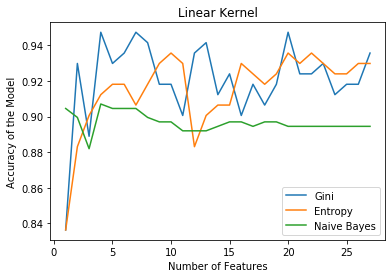

In [73]:
Gini_k = []
Entropy_k = []
Naive_Bayes_k = []

for i in range(1,28):
    kpca = KernelPCA(n_components=i, kernel='linear')
    X_new = kpca.fit_transform(X, Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=.3, random_state=0)
        
    dtGini = DecisionTreeClassifier(criterion='gini', random_state=0)
    dtEntropy = DecisionTreeClassifier(criterion='entropy', random_state=0)
    NB = GaussianNB()

    dtGini.fit(X_train, Y_train)
    dtEntropy.fit(X_train, Y_train)
    NB.fit(X_train, Y_train)
        
    Gini_score = dtGini.score(X_test, Y_test)
    Entropy_score = dtEntropy.score(X_test, Y_test)
    NB_score = NB.score(X_train, Y_train)

    Gini_k.append(Gini_score)
    Entropy_k.append(Entropy_score)
    Naive_Bayes_k.append(NB_score)

t = [i for i in range(1,28)]

plt.plot(t, Gini_k)
plt.plot(t, Entropy_k)
plt.plot(t, Naive_Bayes_k)

plt.legend(['Gini', 'Entropy', 'Naive Bayes'])
plt.title('Linear Kernel')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy of the Model')
plt.show()

$$Χρησιμοποιώντας\ τον\ γραμμικό\ πυρήνα,\ παρατηρούμε\ ότι\ παίρνουμε\ τα\ ίδια\ ποσοστά\ στο\ accuracy\ όπως\ και\ με\ την\ PCA.\ Αυτό\ είναι\\ απόλυτα\ λογικό,\ γιατί\ η\ PCA\ αποτελεί\ την\ ειδική\ περίπτωση\ της\ KPCA\ όπου\ χρησιμοποιούμε\ τον\ γραμμικό\ πυρήνα.$$

$$Τώρα\ θα\ χρησιμοποιήσουμε\ πολυωνυμικό\ πυρήνα\ για\ διάφορες\ τιμές\ του\ βαθμού\ d.$$

In [ ]:
def polynomial(d):
    Gini_kp = []
    Entropy_kp = []
    Naive_Bayes_kp = []

    for i in range(1,28):
        kpca = KernelPCA(n_components=i, kernel='poly', degree=d)
        X_new = kpca.fit_transform(X, Y)
        X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=.3, random_state=0)

        dtGini = DecisionTreeClassifier(criterion='gini', random_state=0)
        dtEntropy = DecisionTreeClassifier(criterion='entropy', random_state=0)
        NB = GaussianNB()

        dtGini.fit(X_train, Y_train)
        dtEntropy.fit(X_train, Y_train)
        NB.fit(X_train, Y_train)

        Gini_score = dtGini.score(X_test, Y_test)
        Entropy_score = dtEntropy.score(X_test, Y_test)
        NB_score = NB.score(X_train, Y_train)

        Gini_kp.append(Gini_score)
        Entropy_kp.append(Entropy_score)
        Naive_Bayes_kp.append(NB_score)
        
    return Gini_kp, Entropy_kp, Naive_Bayes_kp

t = [i for i in range(1,28)]

d = 2
fig, axs = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        Gini_kp, Entropy_kp, Naive_Bayes_kp = polynomial(d)
        axs[i,j].plot(t, Gini_kp, color='orange')
        axs[i,j].plot(t, Entropy_kp, color='blue')
        axs[i,j].plot(t, Naive_Bayes_kp, color='green')
        axs[i,j].set_xlabel('Number of Features')
        axs[i,j].set_ylabel('Accuracy')
        axs[i,j].set_title('Degree =' + str(d))
        d += 1

for ax in axs.flat:
    ax.label_outer()

plt.show()

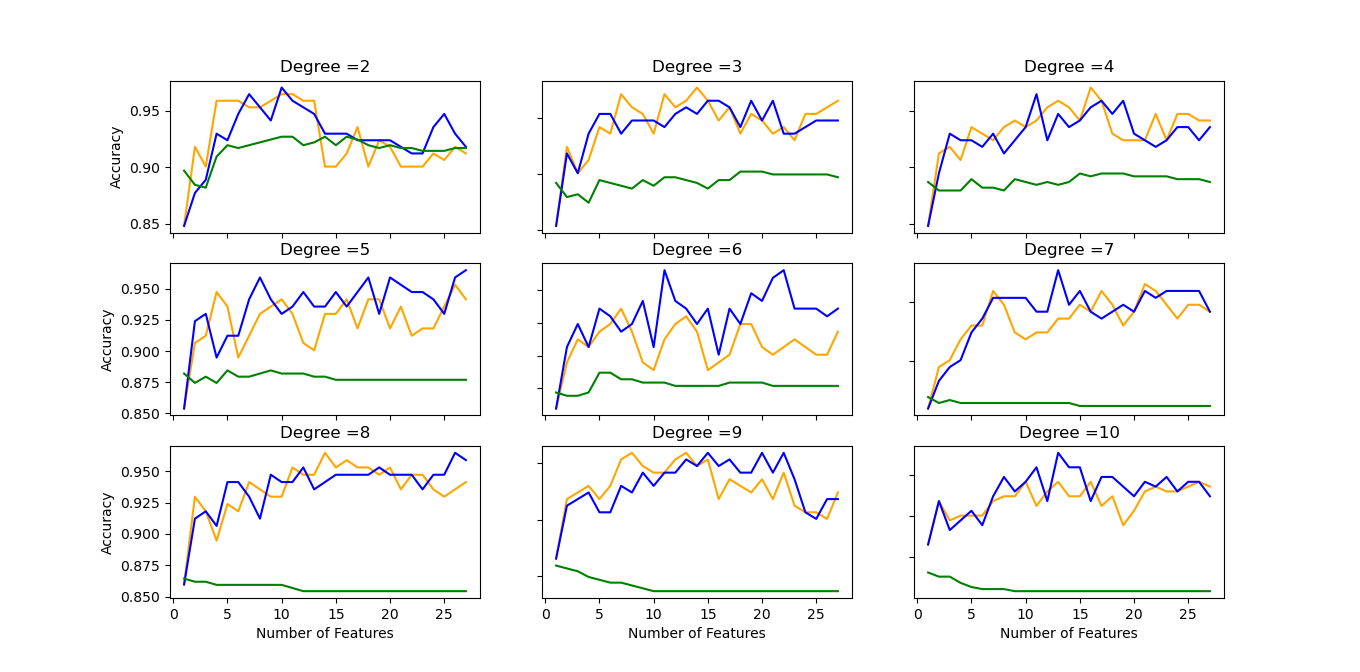

$$Εδώ\ παρατηρούμε\ ότι\ όσο\ αυξάνουμε\ τον\ βαθμό\ του\ πολυωνύμου\ στον\ πυρήνα\ η\ απόδοση\ των\ desicion\ trees\ φαίνεται\ να\ παραμένει\ σταθερή\ για\ τα\ διάφορα\ πλήθη\ επιλογής\ χαρακτηριστικών.\ Αντίθετα\ η\ απόδοση\ του\ Naive\ Bayes\ φαίνεται\ να\ πέφτει.\ Ενδεχομένως\ όσο\ αυξάνουμε\\ τον\ βαθμό\ στον\ Naive\ Bayes\ μπορεί\ να\ προκαλείται\ overfitting\ όταν\ επιλέγουμε\ πολλά\ χαρακτηριστικά,\ γιατί\ επιλέγοντας\ λιγότερα\\ από\ 5\ φαίνεται\ να\ ανταποκρίνεται\ καλύτερα.$$

$$Τώρα\ θα\ τρέξουμε\ τον\ Gaussian\ για\ διάφορες\ τιμές\ τις\ παραμέτρου\ \gamma .$$

In [ ]:
def polynomial(g):
    Gini_kp = []

    for i in range(1,28):
        kpca = KernelPCA(n_components=i, kernel='poly', gamma= g)
        X_new = kpca.fit_transform(X, Y)
        X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=.3, random_state=0)

        dtGini = DecisionTreeClassifier(criterion='gini', random_state=0)

        dtGini.fit(X_train, Y_train)

        Gini_score = dtGini.score(X_test, Y_test)

        Gini_kp.append(Gini_score)

        
    return Gini_kp

t = [i for i in range(1,28)]

g = np.linspace(0, 1, 10)
for gamma in range(len(g)):
    Gini_kp = polynomial(g[gamma])
    plt.plot(t, Gini_kp)

l = []
for i in range(len(g)):
    l.append(str(g[i]))
plt.legend(l)
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Gini for different values of gamma')
plt.show()

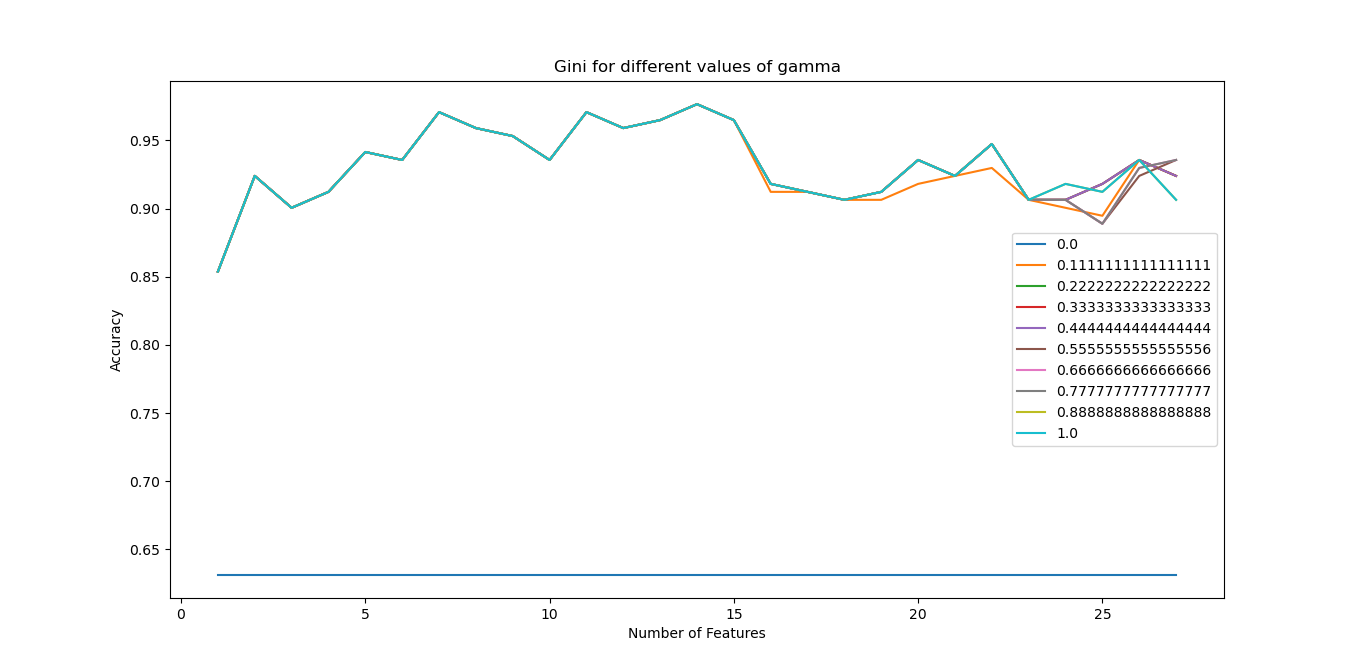

$$Παραπάνω\ βλέπουμε\ πως\ αποδίδει\ ο\ Gini\ για\ τις\ διάφορες\ τιμές\ του\ \gamma .\ Προφανώς\ για\ \gamma =0\ παίρνουμε\ τον\ μηδενικό\ πυρήνα\ ο\ οποίος\\ είναι\ πρακτικά\ άχρηστος.\\ Μια\ παρατήρηση\ που\ μπορούμε\ να\ κάνουμε,\ είναι\ ότι\ ο\ Gini\ αποδίδει\ για\ τις\ διάφορες\ τιμές\ του\ \gamma \ όταν\ επιλέξουμε\ λιγότερα\ από\ 15\\ χαρακτηριστικά,\ έχοντας\ καλύτερο\ accuracy\ επιλέγοντας\ 7-15\ χαρακτηριστικά.$$

In [ ]:
def polynomial(g):
    Entropy_kp = []

    for i in range(1,28):
        kpca = KernelPCA(n_components=i, kernel='poly', gamma= g)
        X_new = kpca.fit_transform(X, Y)
        X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=.3, random_state=0)

        dtEntropy= DecisionTreeClassifier(criterion='entropy', random_state=0)

        dtEntropy.fit(X_train, Y_train)

        Entropy_score = dtEntropy.score(X_test, Y_test)

        Entropy_kp.append(Entropy_score)

        
    return Entropy_kp

t = [i for i in range(1,28)]

g = np.linspace(0, 1, 10)
for gamma in range(1, len(g)):
    print(gamma+1)
    Entropy_kp = polynomial(g[gamma])
    plt.plot(t, Entropy_kp)

l = []
for i in range(1, len(g)):
    l.append(str(g[i]))
plt.legend(l)
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Entropy for different values of gamma')
plt.show()

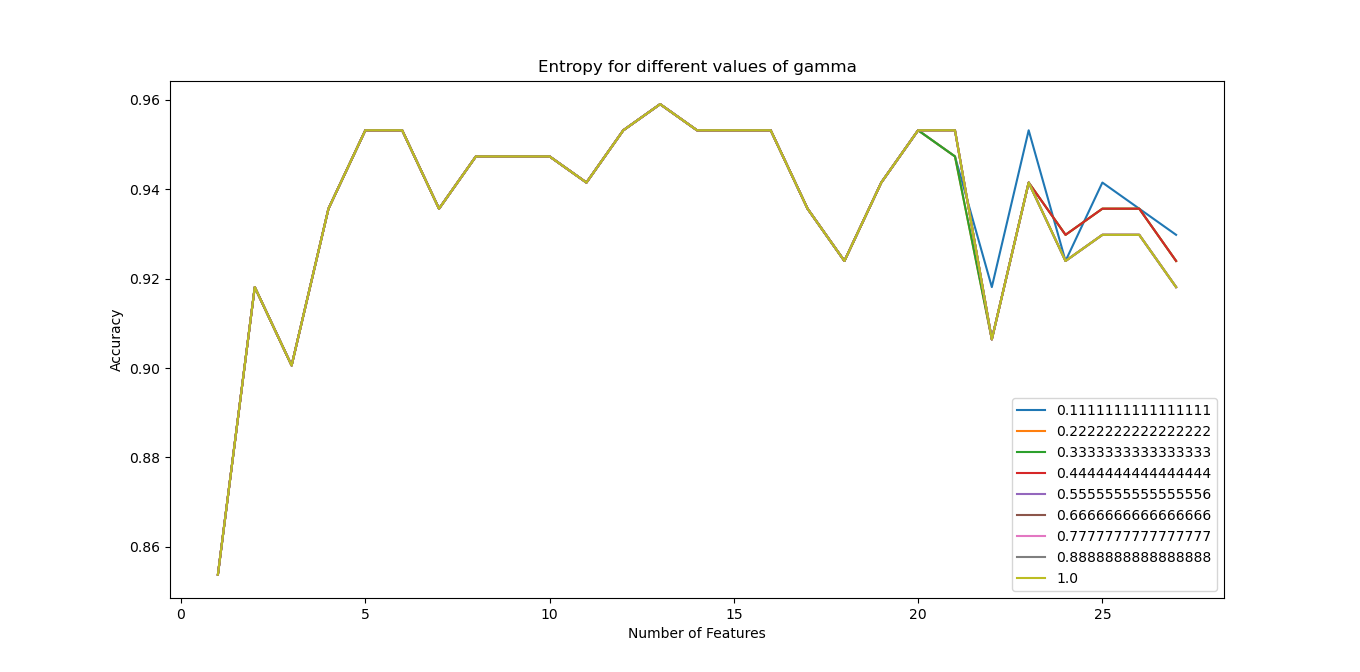

$$Κάνοντας\ την\ ίδια\ δουλειά\ και\ για\ το\ desicion\ tree\ με\ εντροπία,\ παρατηρούμε\ πάλι\ ότι\ υπάρχει\ ένα\ πλήθος\ χαρακτηριστικών\ απ'\ το\ οποίο\\ κι\ έπειτα\ το\ μοντέλο\ παρουσιάζει\ ίδιο\ accuracy\ για\ τις\ διάφορες\ τιμές\ του\ \gamma .\ Αυτό\ το\ κρίσιμο\ πλήθος\ φαίνεται\ να\ είναι\ το\ 20.$$

In [ ]:
def polynomial(g):
    nb_kp = []

    for i in range(1,28):
        kpca = KernelPCA(n_components=i, kernel='poly', gamma= g)
        X_new = kpca.fit_transform(X, Y)
        X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=.3, random_state=0)

        dtnb= GaussianNB()

        dtnb.fit(X_train, Y_train)

        nb_score = dtnb.score(X_test, Y_test)

        nb_kp.append(nb_score)

        
    return nb_kp

t = [i for i in range(1,28)]

g = np.linspace(0, 1, 10)
for gamma in range(1, len(g)):
    print(gamma+1)
    nb_kp = polynomial(g[gamma])
    plt.plot(t, nb_kp)

l = []
for i in range(1, len(g)):
    l.append(str(g[i]))
plt.legend(l)
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Naive Bayes for different values of gamma')
plt.show()

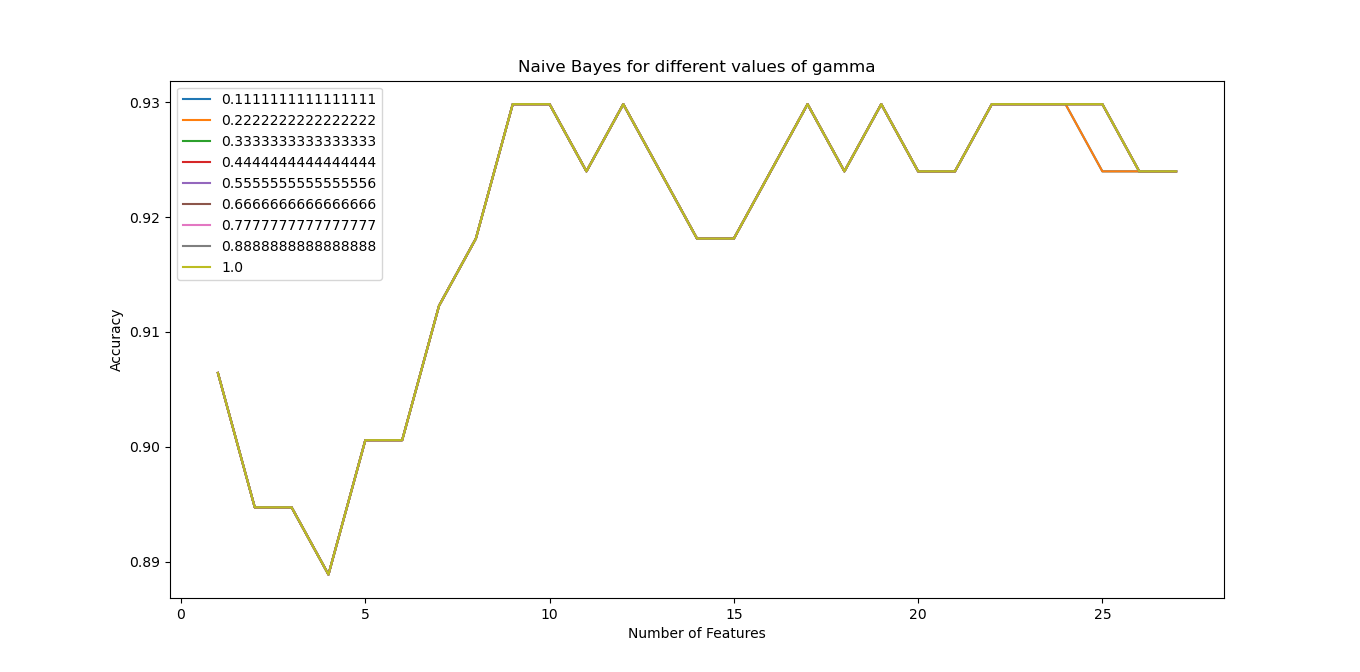

$$Για\ τον\ Naive\ Bayes\ βλέπουμε\ ότι\ το\ accuracy\ παραμένει σχεδόν\ ίδιο\ για\ τις\ διάφορες\ τιμές\ του \gamma ,\ αλλά\ φαίνεται\ να\ είναι\ καλύτερο\\ επιλέγοντας\ τουλάχιστον\ 10\ το\ πλήθος\ χαρακτηριστικά.$$